# Parker Dunn

__Assignment for COURSERA: Introduction to Deep Learning (via CU Boulder)__  
__Assignment:__ Week 3 - CNN Cancer Detection Kaggle Mini-Project

# Step 4

## Step 4 - Part 1 - Displaying designs tested and analyzing CNN model

Before moving on to hyperparameter tuning, I have included a brief summary of the designs that I tested below. Then, I discuss some of the techniques used to improve the overall success of my model design (- I tested these in the previous step while testing other model design features).

In [3]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

PATH="drive/MyDrive/IntroToDL_CancerMiniProject"

cnn_designs = pd.read_csv(f"{PATH}/cnn_designs_tested.csv")
print(cnn_designs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          date  val_accuracy  num_conv_layers  num_neuron_layers
0   2022-07-19            58                6                  3
1   2022-07-19            62                9                  3
2   2022-07-19            60                9                  3
3   2022-07-19            58                9                  3
4   2022-07-19            61                9                  3
5   2022-07-19            38                9                  3
6   2022-07-19            60                9                  3
7   2022-07-25            81                5                  3
8   2022-07-25            63                8                  3
9   2022-07-25            76                8                  3
10  2022-07-25            59                8                  5
11  2022-07-25            59                8                  5
12  2022-07-25            

I introduced some normalization techniques toward the end of my design testing procedure.

First, I started introducing batch normalization into the convolution layers of the model. I noticed initial improvement compared to the similar designs that I had already tested and decided to include a batch noramlization layer in each Conv-Conv-Pool block. I did not extensively experiment with the effects of batch normalization though.

Second, I introduced dropout layers in the neural network. I tried dropout rates between 0.1 and 0.5. Designs with lots of parameters had better results with rates around 0.3, but slightly lower rates worked better for models of the size that I chose in the end. Thus, I use 0.2 as the dropout rate in both of the dropout layers.



## Step 4 - Part 2 - Preparation: loading packages, loading data, preparing model, etc.

In [ ]:
import os
import shutil

# import pandas as pd
# import numpy as np
from skimage import io

import glob
import matplotlib.pyplot as plt

from datetime import datetime
import json
import pathlib

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers


# CONNECTING TO GOOGLE DRIVE & KAGGLE DATA

print("Working directory...")
!pwd

# from google.colab import drive
# drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = "drive/MyDrive"
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -q histopathologic-cancer-detection.zip

# RE-ARRANGING THE IMAGE FILES TO BE COMPATIBLE WITH tf.keras.utils.images_from_directory...

!mkdir train/pos
!mkdir train/neg


y_info = pd.read_csv("train_labels.csv", header=0)

for i in range(y_info.shape[0]):
  f = y_info.loc[i,"id"]
  img = io.imread("train/"+f+".tif")

  if y_info.loc[i,"label"]:   # "== 1"
    io.imsave("train/pos/"+f+".jpg", img, check_contrast=False, quality=100)
    os.remove("train/"+f+".tif")
  else:
    os.remove("train/"+f+".tif")
    io.imsave("train/neg/"+f+".jpg", img, check_contrast=False, quality=100)


# CRITICAL VARIABLES

test_locs = os.listdir("test/")

PATH="drive/MyDrive/IntroToDL_CancerMiniProject/"
TRAIN = pathlib.Path("train/")
TEST= pathlib.Path("test/")

batch_size=64
img_dim=96

LEARNING_RATES = [0.0001, 0.001, 0.01]
N_EPOCHS = 5

Working directory...
/content
Mounted at /content/drive
100% 6.28G/6.31G [00:46<00:00, 125MB/s]
100% 6.31G/6.31G [00:47<00:00, 144MB/s]


In [ ]:
# HELPER FUNCTIONS

def load_test_image(FILE_PATH):
    img = io.imread(FILE_PATH)
    return img

def load_batch(FILES):
    n = len(FILES)
    imgs = np.zeros((n,96,96,3), dtype=np.int8)
    for i in range(n):
        img = io.imread("test/"+FILES[i])
        # f = (FILES[i].split([".","/"])[-2])
        imgs[i,:,:,:] = img
    return imgs

def evaluate_test_images(model, img_files):
    image_ids = []
    raw_outputs = []
    results = []

    iter = 0
    while (len(img_files) - iter) > 128:
        batch_files = img_files[iter:(iter+64)]
        imgs = load_batch(batch_files)
        batch_img_ids = [f[:-4] for f in batch_files]

        iter += 64
        image_ids.extend(batch_img_ids)
        
        batch_result = model.predict(imgs)
        raw_outputs.extend(batch_result[:,0])
        batch_result = np.where(batch_result > 0.5, 1, 0)
        results.extend(batch_result[:,0])
    

    batch_files = img_files[iter:]
    imgs = load_batch(batch_files)
    batch_img_ids = [f[:-4] for f in batch_files]

    image_ids.extend(batch_img_ids)
    
    batch_result = model.predict(imgs)
    raw_outputs.extend(batch_result[:,0])
    # print(batch_result[0:5])            # debugging
    # print(type(batch_result))           # debugging
    batch_result = np.where(batch_result > 0.5, 1, 0)
    # print(batch_result[0:5])            # debugging
    # print(type(batch_result))           # debugging
    results.extend(batch_result[:,0])

    return pd.DataFrame({'id':image_ids, 'label':results, 'raw_output':raw_outputs})

# TESTING "load_batch" FUNCTION
sample_batch = load_batch(test_locs[0:64])
print(sample_batch.shape)

(64, 96, 96, 3)


In [ ]:
# LOADING IMAGE INFO FOR TENSORFLOW

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN,
    validation_split=0.33,
    subset="training",
    seed=123,
    image_size=(img_dim, img_dim),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN,
    validation_split=0.33,
    subset="validation",
    seed=123,
    image_size=(img_dim, img_dim),
    batch_size=batch_size)

# FUNCTION TO CREATE MODEL AND TRAIN - allows me to easily test hyperparameters

def train_model(train_ds, val_ds, learning_rate, num_epochs):
    model = tf.keras.Sequential([
        layers.Rescaling(1./255),
        layers.Cropping2D(cropping=((12,12),(12,12)), data_format="channels_last"),
        layers.Conv2D(16, (7,7), activation='relu', padding='valid', input_shape=(72,72,3)),
        layers.Conv2D(16, (5,5), activation='relu', strides=(2,2), padding='same'),
        layers.BatchNormalization(axis=-1),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPool2D((2,2), strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPool2D((2,2), strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    results = model.fit(train_ds, verbose=0, validation_data=val_ds, epochs=num_epochs)

    return results, model

Found 220025 files belonging to 2 classes.
Using 147417 files for training.
Found 220025 files belonging to 2 classes.
Using 72608 files for validation.


____

## Step 4 - Part 3 - Tuning hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 cropping2d (Cropping2D)     (None, 72, 72, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 66, 66, 16)        2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 16)        6416      
                                                                 
 batch_normalization (BatchN  (None, 33, 33, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 32)        4640      
                                                        

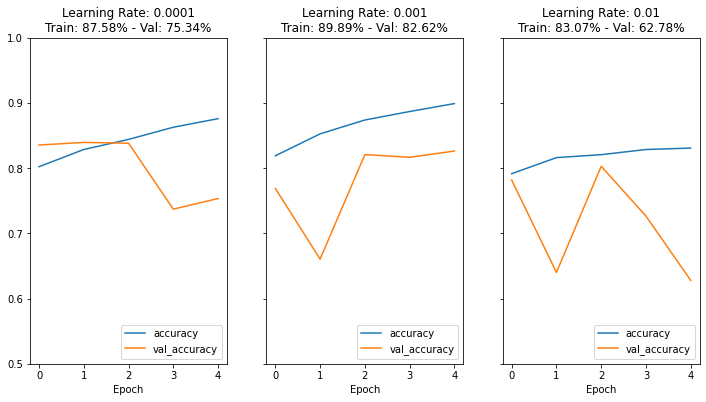

In [ ]:
results = []

# Retrieving information so I can save model results
now_obj = datetime.now()
now_date = now_obj.strftime("%Y_%m_%d")
now_time = (now_obj.hour * 3600) + (now_obj.minute * 60) + now_obj.second
now = f"{now_date}_{now_time}"

counter=0
for eta in LEARNING_RATES:
    # Train a model with the selected learning rate
    run_results, model = train_model(train_ds, val_ds, eta, N_EPOCHS)
    if counter < 1:
        model.summary()
        counter += 1
    # Save results for plotting later
    results.append(run_results)
    # Saving model info
    filename = f"{PATH}model_tuning/{now}_model_{eta}"
    model.save(filename)  # all other parameters default to the values I wanted

# Viewing the results
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=3, sharey=True)
plt.subplots_adjust(wspace=0.2)

for i in range(len(LEARNING_RATES)):
    axes[i].plot(results[i].history['accuracy'], label='accuracy')
    axes[i].plot(results[i].history['val_accuracy'], label='val_accuracy')
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylim([0.5,1])
    axes[i].legend(loc="lower right")

    val_accuracy = results[i].history['val_accuracy'][-1]
    train_accuracy = results[i].history['accuracy'][-1]
    title = f"Learning Rate: {LEARNING_RATES[i]}\nTrain: {train_accuracy:.2%} - Val: {val_accuracy:.2%}"
    axes[i].set_title(title)

____
## Step 4 - Part 4 - Training model on all data


In [ ]:
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN,
    image_size=(img_dim, img_dim),
    batch_size=batch_size)

results, model = train_model(full_train_ds, None, learning_rate=0.001, num_epochs=4)

# Retrieving information so I can save model results
now_obj = datetime.now()
now_date = now_obj.strftime("%Y_%m_%d")
now_time = (now_obj.hour * 3600) + (now_obj.minute * 60) + now_obj.second
now = f"{now_date}_{now_time}"

filename = f"{PATH}trained_model/{now}_model"
model.save(filename)

Found 220025 files belonging to 2 classes.
INFO:tensorflow:Assets written to: drive/MyDrive/IntroToDL_CancerMiniProject/trained_model/2022_07_30_78856_model_0.01/assets


INFO:tensorflow:Assets written to: drive/MyDrive/IntroToDL_CancerMiniProject/trained_model/2022_07_30_78856_model_0.01/assets


Text(0.5, 1.0, 'Final Accuracy: 90.02%')

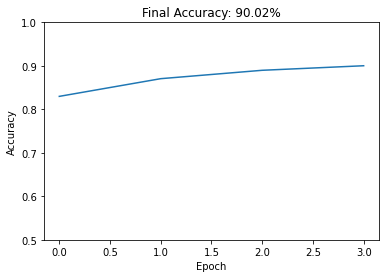

In [ ]:
plt.plot(results.history['accuracy'], label='accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
info = results.history['accuracy'][-1]
plt.title(f"Final Accuracy: {info:0.2%}")

____
## Step 4 - Part 5 - Loading trained model and evaluating on test images

Location of trained model: `/content/drive/MyDrive/IntroToDL_CancerMiniProject/trained_model/2022_07_30_78856_model_0.01`

A function was prepared above to assist with loading and evaluating each test image._

In [ ]:
model = tf.keras.models.load_model(f"{PATH}trained_model/2022_07_30_78856_model_0.01")

model.summary()

results = evaluate_test_images(model, test_locs)

results.head(50)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 cropping2d_4 (Cropping2D)   (None, 72, 72, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 66, 66, 16)        2368      
                                                                 
 conv2d_25 (Conv2D)          (None, 33, 33, 16)        6416      
                                                                 
 batch_normalization_12 (Bat  (None, 33, 33, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 33, 33, 32)        4640      
                                                      

,id,label,raw_output
0,85d9432affc77081cdc4d5b2096fae753af6a92a,0,0.224708
1,70b07901f6feceb5ae3117dbd3e1c760d11828c6,0,0.002030
2,fb80a92c0752ab95348f67ff128b4c33000acf15,0,0.004425
3,1f4d06a31c6ca570688cb9f18ccf6b830d8ad47c,1,0.614557
4,a46467785c534514e5262487f48e9f16220d8ba7,0,0.003638
5,7c18770c71828d498c1c3909b9bc166ca4a707ef,0,0.001758
6,db2b03c8f5ba880fff9fc82446d71c8947ba144a,0,0.111266
7,83d3145e1a3ea76227598e6b2ab6620166886563,0,0.001881
8,2a9bf3b7f75fdac13d884143374c51bc4403faed,0,0.307400
9,221dc0ce0a0349ca75cfeda4bb296148d93d6b8f,0,0.168946


In [ ]:
# SAVING THE TESTING RESULTS AND COUNTING THE NUMBER OF 1s/0s
test_counts = results.loc[:,"label"].value_counts()
print(test_counts)

results.loc[:,["id","label"]].to_csv(f"{PATH}/submission.csv", index=False)

0    44871
1    12587
Name: label, dtype: int64
